# MODELO 2 - sabendo genero do filme

# POR ACABAR !!!!!!!!!!

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings

#warnings.filterwarnings("ignore")

# Load the data

In [2]:
df_train = pd.read_csv("data/data_train.csv")
df_test = pd.read_csv("data/data_test.csv")

In [3]:
with open("data/data_ids.json") as f:
    ids = json.load(f)

max_movieId = max(ids["moviesIDs"].values())
max_userId = max(ids["userIDs"].values())

# Create a matrix of users and movies
base_matrix = np.zeros((max_movieId + 1, max_userId + 1))
base_matrix.shape

(9633, 385)

In [4]:
df_genre = pd.read_csv("data/movies.csv")

# Define functions

In [5]:
# Utility matrix and Binary matrix
from scipy.sparse import lil_matrix

def utility_matrix_AND_binary_matrix(dfTrain, zerosMatrix = base_matrix, jsonIds = ids):
    Y = lil_matrix(zerosMatrix.shape)  # Use sparse matrix format
    R = lil_matrix(zerosMatrix.shape)
    for i, row in dfTrain.iterrows():
        original_movieId, original_userId = int(row["movieId"]), int(row["userId"])
        movieId = jsonIds["moviesIDs"][str(original_movieId)]
        userId = jsonIds["userIDs"][str(original_userId)]
        Y[movieId, userId] = row["rating"]
        R[movieId, userId] = 1
    return Y, R

In [6]:
def cofiCostFunc_Xknown(params, X, Y, R, num_users, num_movies, num_features, Lambda):
    """
    Returns the cost and gradient for the collaborative filtering
    Lambda - regularization parameter
    """
        
    # Unfold the params
    Theta = params
    
    predictions =  X @ Theta.T
    err = (predictions - Y)
    J = 1/2 * np.sum((err**2) * R)
    
    #compute regularized cost function
    reg_Theta = Lambda/2 *np.sum(Theta**2)
    reg_J = J + reg_Theta
    
    # Compute gradient
    Theta_grad = (err*R).T @ X
    grad = Theta_grad
    
    # Compute regularized gradient
    reg_Theta_grad = Theta_grad + Lambda*Theta
    reg_grad = reg_Theta_grad
    
    return J, grad, reg_J, reg_grad

In [7]:
def gradientDescent_Xknown(initial_parameters,X,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda):
    """
    alpha - learning rate
    Optimize X and Theta
    """
    # unfold the initial parameters (consult function cofiCostFunc)
    Theta = initial_parameters
    
    J_history =[]
    
    for i in range(num_iters):
        #Append into a single vector params X and Theta (see above)
        params = Theta
        cost, Theta_grad = cofiCostFunc_Xknown(params, X, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        #Update trainable parameters X & Theta applying gradient descent method        
        Theta = Theta - alpha*Theta_grad
        
        J_history.append(cost)
    
    #Append into a single vector paramsFinal the updated X and Theta
    paramsFinal = Theta
    return paramsFinal , J_history

# Set model features: X (movies genres as features)

In [8]:
num_movies, num_users = base_matrix.shape

genres = df_genre["genres"].str.split("|").tolist()
genres = {genre: 0 for sublist in genres for genre in sublist}
# create X: movies features
X = np.zeros((num_movies, len(genres))) # 20 genres
for movie in ids["moviesIDs"]:
    movieId_matrix = ids["moviesIDs"][movie]
    genre_dict = genres.copy()
    genres_list = df_genre[df_genre["movieId"] == int(movie)]["genres"].str.split("|").tolist()[0]
    for genre in genres_list:
        genre_dict[genre] = 1 / len(genres_list)
    X[movieId_matrix] = list(genre_dict.values())

X.shape


# for later on Theta: users 
#num_features = len(genres)
#Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))

#params = np.append(X.flatten(),Theta.flatten())
#, Theta.shape

(9633, 20)

In [9]:
X.shape

(9633, 20)

In [10]:
num_features = len(genres)
Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
Y, R = utility_matrix_AND_binary_matrix(df_train)
Y, R = Y.toarray(), R.toarray()
Lambda = 1

params = Theta

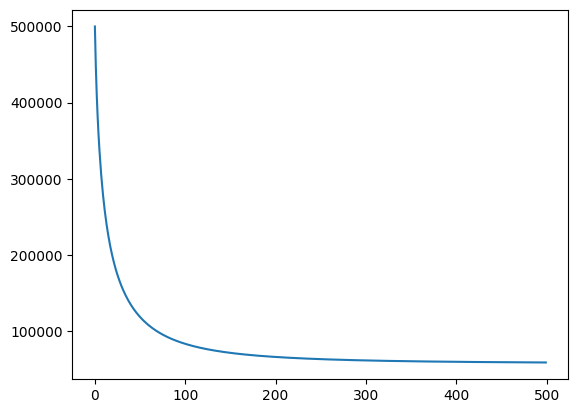

In [11]:
initial_parameters = Theta
alpha = 0.001
num_iters = 500
a,b = gradientDescent_Xknown(initial_parameters,X,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda)
plt.plot(b)

In [12]:
a

array([[ 4.98501606,  3.24956909,  4.25376761, ...,  1.16430373,
        -0.05247177, -0.07035556],
       [ 3.21155922,  1.23199669,  1.83124178, ...,  2.0773437 ,
         0.42064939,  0.18845401],
       [ 4.11929375,  1.78829831,  3.57053664, ...,  2.27458506,
         0.19917174, -0.02130708],
       ...,
       [ 2.73015617,  0.92968082,  2.1909154 , ...,  0.63035327,
         0.26699814, -0.06435152],
       [ 3.68105972,  3.2793973 ,  1.07395743, ...,  1.24564348,
         0.6488068 , -0.13678569],
       [ 4.05392019,  3.81489501,  2.53027942, ...,  3.18979092,
         0.93475599,  0.30471283]], shape=(385, 20))

# A FALTAR 8CV, E ESSAS TRETAS TODAS, SO TEMOS FUNCOES DE CUSTO O E POUCO MAIS